# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or is the correlation purely due to another common cause?

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets, dowhy.plotter

# Let's create a mystery dataset. Need to find if there is a causal effect.

Creating the dataset. It is generated from either of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [3]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, sd_error=0.2)                                               
df = data_dict['df']                                                                                 
display(df[["Treatment", "Outcome", "w0"]].head())                                                                                                     
                                                                                                                                                                                                         

,Treatment,Outcome,w0
0,9.766411,19.721863,3.999283
1,2.289335,4.808221,-3.693092
2,2.640429,5.400763,-3.388469
3,2.719334,4.786587,-3.877955
4,2.709079,5.536214,-3.154525


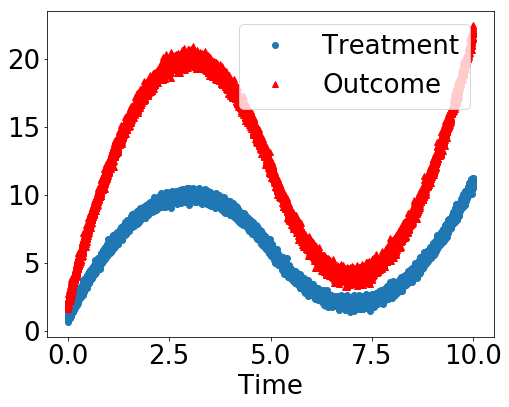

In [4]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

# Using DoWhy to resolve the mystery: *Does Treatment cause Outcome variable?*
## STEP 1: Model the problem as a causal graph
Initializing the causal model.

In [11]:
import networkx as nx
g = nx.DiGraph()
g.node

Model to find the causal effect of treatment Treatment on outcome Outcome
Using Matplotlib for plotting


/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Users/zuck016/.pyenv/versions/anacon

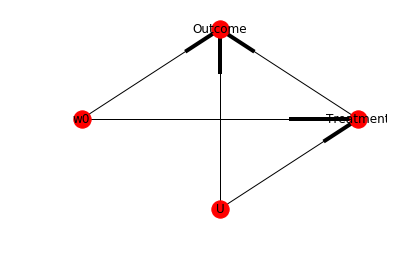

In [5]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

Showing the causal model stored in local file "causal_model.png"

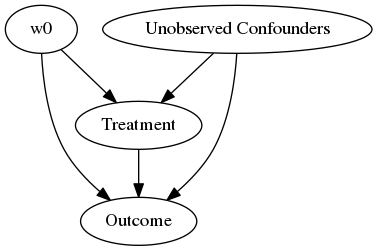

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'w0', 'U'}


{'observed': 'yes'}
{'observed': 'no', 'label': 'Unobserved Confounders'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
    d                              
──────────(Expectation(Outcome|w0))
dTreatment                         
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)



## STEP 3: Estimate the causal effect

Once we have the identified estimand, can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


LinearRegressionEstimator
Causal Estimate is 0.0180444904797


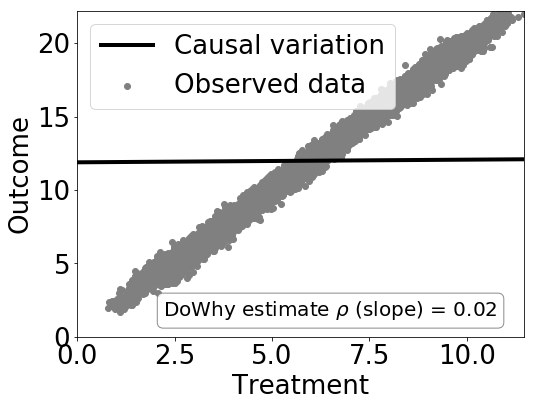

In [8]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [9]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 0.0180444904797
Actual true causal effect was 0


## Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [10]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.018044490479725939,)
New effect:(0.017899599388015757,)



### Replacing treatment with a random (placebo) variable

In [11]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


Refute: Use a Placebo Treatment
Estimated effect:(0.018044490479725939,)
New effect:(0.00017882059335885532,)



### Removing a random subset of the data

In [12]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Refute: Use a subset of data
Estimated effect:(0.018044490479725939,)
New effect:(0.018649516996423924,)



As you can see, our causal estimator is robust to simple refutations.